In [1]:
import math 
import numpy as np
import os 
import json
import csv
import argparse
import matplotlib
%matplotlib inline 

In [2]:
xg = [-0.9815606, -0.9041173, -0.7699027, -0.5873180, -0.3678315, -0.1252334,  0.1252334,  0.3678315,  0.5873180, 0.7699027, 0.9041173,  0.9815606]
wg = [0.04717534, 0.10693933, 0.16007833, 0.20316743, 0.23349254, 0.24914705, 0.24914705, 0.23349254, 0.20316743, 0.16007833, 0.10693933, 0.04717534]
ng = 12
hL = 1.0
pi = 3.141592654
degtorad = np.pi/180
radtodeg = 180/np.pi
phiprime = 0
thetaprime = 150*degtorad
muprime = np.cos(thetaprime)
# Discrete Ordinates 
#number of spatial nodes 
Nlayers = 100
#convergence criterion 
Epsilon = 0.0001
#polar angle of the sun
theta_o = 120.0
#azimuth angle of the sun
phi_o = 0.0
theta_o = theta_o*degtorad
phi_o = phi_o*degtorad
mu_o = np.cos(theta_o)
#total incident flux density 
Ftot = 1.0
#fraction of Ftot in the direct solar beam 
fdir = 0.7
#intensity of the direct beam 
I_o = Ftot*(fdir/(abs(mu_o)))
#intensity of diffuse sky light 
I_d = Ftot*(1-fdir)/np.pi
#leaf area per unit ground area (LAI = 1-5?)
#LAI = 1.0
#thickness of spatial cells 
#DeltaL = LAI/Nlayers
#leaf hemispherical reflectance 
#rho_Ld = 0.075
#leaf hemispherical transmittance 
#tau_Ld = 0.035
#soil hemispherical reflectance (R_s = 0.125 and 0)
#R_s = 0.125


In [3]:
def gL_planophile(thetaL):
    planophile_pdf = (2 / np.pi) * (1 + np.cos(2 * (thetaL)))
    return(planophile_pdf)
  

In [4]:
def G_dir(ng, xg, wg, hL, muprime, phiprime, canopy):
    mu_tp = muprime
    sin_tp = np.sqrt(1-(muprime*muprime))
  
  #define limits over theta
    up_tL = np.pi / 2.0
    low_tL = 0.0
    C_tL = (up_tL-low_tL) / 2.0
    D_tL = (up_tL+low_tL) / 2.0
  
  #define limits over phi 
    up_pL = 2.0 * pi
    low_pL = 0.0
    C_pL = (up_pL-low_pL) / 2.0
    D_pL = (up_pL+low_pL) / 2.0
  
    gL = np.zeros(ng)
  #integral over theta
    sum_tL = 0.0
    for i in range(ng): 
        new_ord_tL = C_tL*xg[i] + D_tL
        mu_tL = np.cos(new_ord_tL)
        sin_tL = np.sin(new_ord_tL)
    
    #get leaf normal pdf 
        gL[i] = canopy(new_ord_tL)
    
    #integral over phi 
        sum_pL = 0.0
        for j in range(ng): 
            new_ord_pL = C_pL*xg[j] + D_pL
            dotproduct = abs(mu_tL*mu_tp + sin_tL*sin_tp*np.cos(new_ord_pL-phiprime))
            sum_pL = sum_pL + wg[j]*hL/(2.0*pi)*dotproduct
    
    #finish phi integral
        sum_pL = sum_pL*C_pL
        sum_tL = sum_tL + wg[i]*gL[i]*sum_pL
  
  #finish theta integral
    sum_tL = sum_tL*C_tL
    Gdir = sum_tL
    return Gdir

In [5]:
#G Diff function
def G_diff(ng, xg, wg, hL, canopy):
    up_pp = 2*pi
    low_pp = 0
    C_pp = (up_pp-low_pp)/2
    D_pp = (up_pp+low_pp)/2

    gdiff_matrix = np.zeros((ng,ng))

    for i in range(ng):
        muprime = xg[i]
        for j in range(ng):
            phiprime = C_pp*xg[j] + D_pp
            gdiff_matrix[j,i] = G_dir(ng,xg,wg,hL,muprime,phiprime,canopy)
  #check for normalization
    sum_tp = 0 
    for i in range(7,ng):
        sum_pp = 0
        for j in range(ng):
            sum_pp = sum_pp + (wg[j] * gdiff_matrix[j,i])
        sum_pp = sum_pp*C_pp
        sum_tp = sum_tp + (wg[i]*sum_pp)
    sum_tp = sum_tp / (2*pi)
  #return(sum_tp)
    return(gdiff_matrix)

In [6]:
#Gamma_d function
#calculate Gamma_d given a direction of photon incidence (muprime,phiprime)
#and direction of scattered photon travel (mu,phi)
def Gamma_d(ng,xg,wg,hL,rho_Ld,tau_Ld,muprime,phiprime,mu,phi,canopy):
    mu_t = mu
    mu_tp = muprime
    sin_t = np.sqrt(1-mu*mu)
    sin_tp = np.sqrt(1-muprime*muprime)
    gL = np.zeros(ng)

      #define limits of integration over thetaL
    up_tL = pi/2
    low_tL = 0
    C_tL = (up_tL-low_tL)/2
    D_tL = (up_tL+low_tL)/2

      #define limits of integration of phiL
    up_pL = 2*pi
    low_pL = 0
    C_pL = (up_pL-low_pL)/2
    D_pL = (up_pL+low_pL)/2

      #integrate over theta L 
    sum_tL = 0 
    for i in range(ng):
        neword_tL = (C_tL*xg[i]) + D_tL
    
        gL[i] = canopy(neword_tL)
    
        mu_tL = np.cos(neword_tL)
        sin_tL = np.sin(neword_tL)
    
    #integrate over phi L 
        sum_pL = 0
        for j in range(ng):
            neword_pL = (C_pL*xg[j]) + D_pL
            dotproduct1 = ((mu_tL*mu_tp) + (sin_tL*sin_tp*np.cos(neword_pL-phiprime)))
            dotproduct2 = ((mu_tL*mu_t) + (sin_tL*sin_t*np.cos(neword_pL-phi)))

            if (dotproduct1*dotproduct2) <= 0:
                sum_pL = sum_pL + rho_Ld*wg[j]*hL/(2*pi)*abs(dotproduct1*dotproduct2)
            else:
                sum_pL = sum_pL + tau_Ld*wg[j]*hL/(2*pi)*abs(dotproduct1*dotproduct2)
    #finish integral over phi L 
        sum_pL = sum_pL*C_pL
        sum_tL = sum_tL + wg[i]*gL[i]*sum_pL
  
    sum_tL = sum_tL*C_tL
    gammad = sum_tL
  
    return(gammad)

In [7]:
#Gamma_d_dir function 
#(phiprime,muprime->phi,mu) where (mu,phi) are all quadrature directions
def GAMMA_d_dir(ng,xg,wg,hL,rho_Ld,tau_Ld,muprime,phiprime,canopy):
  #conversion to have ordinates simulate phi
    up = 2*pi
    low = 0
    C1 = (up-low)/2
    C2 = (up+low)/2
  
  #get Gamma_d_dir matrix direction by direction
    d_dir_matrix = np.zeros((ng,ng))
    for i in range(ng):
        mu = xg[i]
        for j in range(ng):
            phi = (C1*xg[i]) + C2
            d_dir_matrix[j , i] = Gamma_d(ng,xg,wg,hL,rho_Ld,tau_Ld,muprime,phiprime,mu,phi,canopy)
    return(d_dir_matrix)


In [8]:
#Gamma_d_dif
#(muprime,phiprime->mu,phi) where both the incident and exit directions are all quadrature directions 
def GAMMA_d_dif(ng,xg,wg,hL,rho_Ld,tau_Ld,canopy,Gdif):
    up = 2*pi
    low = 0 
    C1 = (up-low)/2
    C2 = (up+low)/2

    dummy = np.zeros((ng,ng))
    gamma_d_dif = np.zeros((ng,ng,ng,ng))
  
    for i in range(ng):
        muprime = xg[i]
        for j in range(ng):
            phiprime = C1*xg[j] + C2
            dummy = GAMMA_d_dir(ng,xg,wg,hL,rho_Ld,tau_Ld,muprime,phiprime,canopy)
            check = check_gamma_d_dir(ng,xg,wg,rho_Ld,tau_Ld,Gdif[j,i],dummy)
            for m in range(ng):
                for n in range(ng):
                    gamma_d_dif[j,i,n,m] = dummy[n,m]
    #return(check)
    return(gamma_d_dif)

def check_gamma_d_dir(ng,xg,wg,rho_Ld,tau_Ld,Gdir,Gamma_d_dir):
    up = 2*pi
    low = 0
    C1 = (up-low)/2
    C2 = (up+low)/2
  
    sum_tp = 0
    for i in range(ng):
        sum_pp = 0
        for j in range(ng):
            sum_pp = sum_pp + wg[i]*Gamma_d_dir[j,i]
        sum_pp = sum_pp*C1
        sum_tp = sum_tp + wg[i]*sum_pp
    sum_tp = sum_tp/pi
    sum_tp = sum_tp/(Gdir*(rho_Ld+tau_Ld))
  
    return(sum_tp)


In [9]:
# downward uncollided direct solar radiation 
def I_o_uncol_down(DeltaL,Nlayers,Gdir,I_o,mu_o):
    L1 = 0
    I_o_uc_d = np.zeros(Nlayers)
    for k in range(Nlayers):
        L2 = k*DeltaL - (0.5*DeltaL)
        Prob = np.exp(-(1/abs(mu_o)) * Gdir * (L2-L1))
        I_o_uc_d[k] = I_o * Prob
    return(I_o_uc_d)

In [10]:
# upward uncollided direct solar radiation 
def I_o_uncol_up(DeltaL,Nlayers,Gdir,Gdif,I_o,mu_o,ng,xg,R_s):
    L1 = 0
    L2 = Nlayers*DeltaL
  #uncollided direct solar radiation incident on the ground
    F_o_uc_d_soil = abs(mu_o)*I_o*np.exp(-(1/abs(mu_o))*Gdir*(L2-L1))
  #upward uncollided intensity from reflection by soil of I_o_uc_d_soil
    I_o_uc_u_soil = (R_s/pi)*F_o_uc_d_soil 
  #upward uncollided direct solar intensity layer by layer
    I_o_uc_u = np.zeros((Nlayers,ng,ng))
    for i in range(ng//2,ng):
        for j in range(ng):
            L2 = Nlayers*DeltaL
            for k in range(Nlayers-1,-1,-1):
                L1 = k*DeltaL - (0.5*DeltaL)
                Prob = np.exp(-(1/abs(xg[i]))*Gdif[j,i]*(L2-L1))
                I_o_uc_u[k,j,i] = I_o_uc_u_soil * Prob

    return(F_o_uc_d_soil, I_o_uc_u)

In [11]:
#downward uncollided diffuse sky radiation
def I_d_uncol_down(DeltaL,Nlayers,Gdif,I_d,ng,xg):
    I_d_uc_d = np.zeros((Nlayers,ng,ng))
    for i in range(ng//2):
        for j in range(ng):
            L1 = 0
            for k in range(Nlayers):
                L2 = k*DeltaL-(0.5*DeltaL)
                Prob = np.exp(-(1/abs(xg[i]))*Gdif[j,i]*(L2-L1))
                I_d_uc_d[k,j,i] = I_d * Prob 
    return (I_d_uc_d)

In [12]:
#upward uncollided diffuse sky radiation 
def I_d_uncol_up(DeltaL,Nlayers,Gdif,I_d,ng,xg,wg,R_s):
  #diffuse sky flux density incident on the soil below canopy 
    I_d_uc_u = np.zeros((Nlayers,ng,ng))
    L1 = 0
    L2 = Nlayers*DeltaL
    sum1 = 0
    for i in range(ng//2):
        upperlimit = 2*pi
        lowerlimit = 0
        conv = (upperlimit-lowerlimit)/2
        sum2 = 0
        for j in range(ng):
            Prob = np.exp(-(1/abs(xg[i]))*Gdif[j,i]*(L2-L1))
            I_d_uc_d_soil = I_d * Prob
            sum2 = sum2 + wg[j]*I_d_uc_d_soil
        sum1 = sum1 + wg[i]*abs(xg[i])*sum2*conv
    F_d_uc_d_soil = sum1
  #upward uncollided intensity due to reflection from soil
    I_d_uc_u_soil = F_d_uc_d_soil*(R_s/pi)
  #downward uncollided diffuse sky intensity 
    for i in range(ng//2,ng):
        for j in range(ng):
            L2 = Nlayers*DeltaL
            for k in range(Nlayers-1,-1,-1):
                L1 = k*DeltaL-(0.5*DeltaL)
                Prob = np.exp(-(1/abs(xg[i]))*Gdif[j,i]*(L2-L1))
                I_d_uc_u[k,j,i] = I_d_uc_u_soil * Prob
    return(F_d_uc_d_soil, I_d_uc_u)

In [13]:
#first-collision source Q
def fcs(Nlayers,ng,xg,wg,Gamma_d_dir,Gamma_d_dif,I_o_uc_d,I_o_uc_u,I_d_uc_d,I_d_uc_u):
    Q = np.zeros((Nlayers,ng,ng))
  #first collision source due to I_o_uc_d
    for i in range(ng):
        for j in range(ng):
            for k in range(Nlayers):
                Q[k,j,i] = (1/pi)*Gamma_d_dir[j,i]*I_o_uc_d[k]
  #first collision source due to I_o_uc_u, I_d_uc_d, I_d_uc_u
    for i in range(ng):
        for j in range(ng):
            for k in range(Nlayers):
                upperlimit1 = 1
                lowerlimit1 = -1
                conv11 = (upperlimit1-lowerlimit1)/2
                sum1 = 0
                for n in range(ng):
                    upperlimit2 = 2*pi
                    lowerlimit2 = 0
                    conv21 = (upperlimit2-lowerlimit2)/2
                    sum2 = 0
                    for m in range(ng):
                        sum2 = sum2 + wg[m]*(1/pi)*Gamma_d_dif[m,n,j,i]*(I_o_uc_u[k,m,n]+I_d_uc_d[k,m,n]+I_d_uc_u[k,m,n])
                    sum1 = sum1 + wg[n]*sum2*conv21
                Q[k,j,i] = Q[k,j,i] + sum1*conv11
    return(Q)

In [14]:
#sweep downward in the phase-space mesh and handle bottom boundary condition
def sweep_down(Nlayers,ng,xg,wg,Gdif,DeltaL,JJ,R_s):
    Ic = np.zeros((Nlayers+1,ng,ng))
  #sweep downwards
    for i in range(ng//2):
        for j in range(ng):
            fij = (xg[i]/DeltaL) - (0.5*Gdif[j,i])
            aij = ((0.5*Gdif[j,i]) + (xg[i]/DeltaL)) / fij
            bij = 1/fij
            for k in range(Nlayers):
                Ic[k+1,j,i] = aij*Ic[k,j,i] - bij*JJ[k,j,i]
  #flux density incident on the ground
    sum1 = 0
    for i in range(ng//2):
        upperlimit = 2*pi
        lowerlimit = 0
        conv = (upperlimit-lowerlimit)/2
        sum2 = 0
        for j in range(ng):
            sum2 = sum2 + wg[j]*Ic[Nlayers,j,i]
        sum1 = sum1 + wg[i]*abs(xg[i])*sum2*conv
    Fc_soil = sum1
  #Ic upward at the ground
    for i in range(ng//2,ng):
        for j in range(ng):
            for k in range(Nlayers):
                Ic[k+1,j,i] = (Fc_soil*R_s)/pi
    return(Ic)

In [15]:
#sweep upwards in the phase-space mesh and check for convergence
def sweep_up(Nlayers,ng,xg,wg,Gdif,DeltaL,JJ,Ic,Ic_old,Epsilon):
    #Ic_old = np.zeros((ng,ng))
    #for i in range((ng/2+1),ng): 
        #for j in range(ng): 
            #Ic_old[j,i] = Ic[1,j,i]
  #sweep upwards
    for i in range(ng//2,ng):
        for j in range(ng):
            fij = ((xg[i]/DeltaL)+(0.5*Gdif[j,i]))
            cij = ((xg[i]/DeltaL)-(0.5*Gdif[j,i])) / fij
            dij = 1/fij
            for k in range(Nlayers-1,-1,-1):
                Ic[k,j,i] = cij*Ic[k+1,j,i] + dij*JJ[k,j,i]
                
    #check convergence 
    convergence = True
    for i in range(ng//2,ng):
        for j in range(ng):
            if abs(Ic[1,j,i] - Ic_old[j,i]) > Epsilon:
                convergence = False
                return convergence
    return convergence

In [16]:
def multi_coli_s(Nlayers,ng,xg,wg,Gamma_d_dif,Ic):
    S = np.zeros((Nlayers,ng,ng))
    for i in range(ng):
        for j in range(ng):
            for k in range(Nlayers):
                upperlimit1 = 1
                lowerlimit1 = -1
                conv11 = (upperlimit1-lowerlimit1)/2
                sum1 = 0
                for n in range(ng):
                    upperlimit2 = 2*pi
                    lowerlimit2 = 0
                    conv21 = (upperlimit2-lowerlimit2)/2
                    sum2 = 0
                    for m in range(ng):
                        Ic_cell_center = 0.5*(Ic[k,m,n]+Ic[k+1,m,n])
                        sum2 = sum2 + wg[m]*(1/pi)*Gamma_d_dif[m,n,j,i]*Ic_cell_center
                    sum1 = sum1 + wg[n]*sum2*conv21
                S[k,j,i] = sum1*conv11
    return(S)

In [17]:
def energy_bal(Nlayers, ng, xg, wg, mu_o, Q, S, DeltaL, R_s,
              rho_Ld, tau_Ld, Gdir, Gdif, F_o_uc_d_soil, F_d_uc_d_soil,
              I_o_uc_d, I_d_uc_d, I_o_uc_u, I_d_uc_u, Ic):
    
    upperlimit = 2*pi
    lowerlimit = 0
    conv = (upperlimit-lowerlimit)/2
    
    #uncollided hemispherical transmittance
    HT_uc = F_o_uc_d_soil + F_d_uc_d_soil
    
    #collided hemispherical transmittance 
    sum1 = 0
    for i in range(ng//2):
        sum2 = 0
        for j in range(ng):
            sum2 = sum2 + wg[j]*Ic[Nlayers,j,i]
        sum1 = sum1+wg[i]*abs(xg[i])*sum2*conv
    HT_c = sum1
    
    #uncollided hemispherical reflectance
    L1 = 0
    L2 = Nlayers*DeltaL
    sum1 = 0
    for i in range(ng//2,ng):
        sum2 = 0
        for j in range(ng):
            Prob = np.exp(-(1/abs(xg[i])) * Gdif[j,i] * (L2-L1))
            I_uc_u = ((F_o_uc_d_soil + F_d_uc_d_soil)*R_s/pi)*Prob
            sum2 = sum2 + wg[j]*I_uc_u
        sum1 = sum1 + wg[i]*abs(xg[i])*sum2*conv
    HR_uc = sum1 
    
    #collided hemispherical reflectance
    sum1 = 0
    for i in range(ng//2,ng):
        sum2 = 0
        for j in range(ng):
            sum2 = sum2 + wg[j]*Ic[1,j,i]
        sum1 = sum1 + wg[i]*abs(xg[i])*sum2*conv
    HR_c = sum1
    
    #canopy absorption from I_o_uc_d
    sum1 = 0
    for k in range(Nlayers):
        sum1 = sum1+I_o_uc_d[k]*Gdir
    AB_o_uc_d = sum1*(1-(rho_Ld + tau_Ld))*DeltaL
    
    #canopy absorption from I_o_uc_u
    sum1 = 0
    for k in range(Nlayers):
        for i in range(ng//2,ng):
            sum2 = 0
            for j in range(ng):
                sum2 = sum2+wg[j]*I_o_uc_u[k,j,i]*Gdif[j,i]
            sum1 = sum1+wg[i]*sum2*conv
    AB_o_uc_u = sum1*(1-(rho_Ld+tau_Ld))*DeltaL
    
    #canopy absorption from I_d_uc_d
    sum1 = 0
    for k in range(Nlayers):
        for i in range(ng//2):
            sum2 = 0
            for j in range(ng):
                sum2 = sum2 + wg[j]*I_d_uc_d[k,j,i]*Gdif[j,i]
            sum1 = sum1 + wg[i]*sum2*conv
    AB_d_uc_d = sum1*(1-(rho_Ld+tau_Ld))*DeltaL
    
    #canopy absorption from I_d_uc_u
    sum1 = 0 
    for k in range(Nlayers):
        for i in range(ng//2):
            sum2 = 0
            for j in range(ng):
                sum2 = sum2 + wg[j]*I_d_uc_u[k,j,i]*Gdif[j,i]
            sum1 = sum1 + wg[i]*sum2*conv
    AB_d_uc_u = sum1*(1-(rho_Ld+tau_Ld))*DeltaL
    
    #canopy absorption from I_c
    sum1 = 0
    for k in range(Nlayers):
        for i in range(ng):
            sum2 = 0
            for j in range(ng):
                sum2 = sum2 + wg[j]*Ic[k,j,i]*Gdif[j,i]
            sum1 = sum1 + wg[i]*sum2*conv
    AB_c = sum1*(1-(rho_Ld+tau_Ld))*DeltaL
    AB_uc = AB_o_uc_d + AB_o_uc_u + AB_d_uc_d + AB_d_uc_u
    
    return HT_uc, HT_c, HR_uc, HR_c, AB_uc, AB_c

In [25]:
#zenith angle of the sun
theta_o = 150.0
#azimuth angle of the sun
phi_o = 0.0
theta_o = theta_o*degtorad
phi_o = phi_o*degtorad
mu_o = np.cos(theta_o)
#leaf area per unit ground area (LAI = 1-5?)
#LAI = 5.0
#thickness of spatial cells 
#DeltaL = LAI/Nlayers
#leaf hemispherical reflectance 
rho_Ld = 0.075
#leaf hemispherical transmittance 
tau_Ld = 0.035
#soil hemispherical reflectance (R_s = 0.125 and 0)
R_s = 0.125

In [26]:
HT_uc = np.zeros(ng)
HT_c = np.zeros(ng)
HR_uc = np.zeros(ng)
HR_c = np.zeros(ng)
AB_uc = np.zeros(ng)
AB_c = np.zeros(ng)
LAI = np.arange(0.5,6.5,0.5)

for idx in range(0,ng,1):
    LAI_idx = LAI[idx]
    DeltaL = LAI_idx/Nlayers
    
    JJ = np.zeros((Nlayers,ng,ng))
    Q = np.zeros((Nlayers,ng,ng))
    S = np.zeros((Nlayers,ng,ng))
    Ic = np.zeros((Nlayers+1,ng,ng))
    Ic_old = np.zeros((ng,ng))
    
    Gdir = G_dir(ng, xg, wg, hL, mu_o, phi_o, gL_planophile)
    Gdif = G_diff(ng, xg, wg, hL, gL_planophile)
    
    gamma_d_dir = GAMMA_d_dir(ng,xg,wg,hL,rho_Ld,tau_Ld,mu_o,phi_o,gL_planophile)
    gamma_d_dif = GAMMA_d_dif(ng,xg,wg,hL,rho_Ld,tau_Ld,gL_planophile,Gdif)
    
    I_o_uc_d = I_o_uncol_down(DeltaL,Nlayers,Gdir,I_o,mu_o)
    I_d_uc_d = I_d_uncol_down(DeltaL,Nlayers,Gdif,I_d,ng,xg)
    F_o_uc_d_soil, I_o_uc_u = I_o_uncol_up(DeltaL,Nlayers,Gdir,Gdif,I_o,mu_o,ng,xg,R_s)
    F_d_uc_d_soil, I_d_uc_u = I_d_uncol_up(DeltaL,Nlayers,Gdif,I_d,ng,xg,wg,R_s)
    
    for ims in range(25):
        Q = fcs(Nlayers,ng,xg,wg,gamma_d_dir,gamma_d_dif,I_o_uc_d,I_o_uc_u,I_d_uc_d,I_d_uc_u)
        S = multi_coli_s(Nlayers,ng,xg,wg,gamma_d_dif,Ic)
        for i in range(ng):
            for j in range(ng):
                for k in range(Nlayers):
                    S[k,j,i] = Q[k,j,i] + S[k,j,i]
                    
        JJ = Q + S
        Ic = sweep_down(Nlayers,ng,xg,wg,Gdif,DeltaL,JJ,R_s)
        for i in range(ng//2,ng):
            for j in range(ng):
                Ic_old[j,i] = Ic[0,j,i]
        convergence = sweep_up(Nlayers,ng,xg,wg,Gdif,DeltaL,JJ,Ic,Ic_old,Epsilon)
        if (convergence):
            break
            
    HT_uc[idx],HT_c[idx],HR_uc[idx],HR_c[idx],AB_uc[idx],AB_c[idx] = energy_bal(Nlayers, ng, xg, wg, mu_o, Q, S, DeltaL, R_s,
                                                                                rho_Ld, tau_Ld, Gdir, Gdif, F_o_uc_d_soil, F_d_uc_d_soil,
                                                                                I_o_uc_d, I_d_uc_d, I_o_uc_u, I_d_uc_u, Ic)

In [21]:
#red BHR, BHT, and AB
#R_s = 0
#rho_Ld = 0.075
#tau_Ld = 0.035
HT_red_black = HT_uc + HT_c
HR_red_black = HR_uc + HR_c
AB_red_black = AB_uc + AB_c

In [30]:
HR_red_black

array([0.06195629, 0.0870844 , 0.09758531, 0.10204879, 0.10396803,
       0.10480295, 0.10517276, 0.10534222, 0.10542506, 0.10547027,
       0.10549898, 0.10552035])

In [31]:
HR_red_black*0.3

array([0.01858689, 0.02612532, 0.02927559, 0.03061464, 0.03119041,
       0.03144089, 0.03155183, 0.03160267, 0.03162752, 0.03164108,
       0.0316497 , 0.03165611])

In [27]:
#red BHR, BHT, and AB
#R_s = 0.125 (typical soil reflectance)
#rho_Ld = 0.075
#tau_Ld = 0.035
HT_red_soil = HT_uc + HT_c
HR_red_soil = HR_uc + HR_c
AB_red_soil = AB_uc + AB_c

In [28]:
HR_red_soil

array([0.14344665, 0.12237575, 0.11295768, 0.10876447, 0.10690621,
       0.10608938, 0.10573621, 0.10558906, 0.1055332 , 0.10551765,
       0.10551974, 0.10552945])

In [29]:
HR_red_soil*0.3

array([0.04303399, 0.03671273, 0.03388731, 0.03262934, 0.03207186,
       0.03182681, 0.03172086, 0.03167672, 0.03165996, 0.03165529,
       0.03165592, 0.03165883])

In [49]:
#NIR BHR, BHT, and AB
#R_s = 0
#rho_Ld = 0.475
#tau_Ld = 0.45
HT_nir_black = HT_uc + HT_c
HR_nir_black = HR_uc + HR_c
AB_nir_black = AB_uc + AB_c
HR_nir_black1 = HR*0.3
HR_nir_black1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [46]:
#NIR BHR, BHT, and AB
#R_s = 0.2 (typical soil reflectance)
#rho_Ld = 0.475
#tau_Ld = 0.45
HR_nir_soil = HR_uc + HR_c
HT_nir_soil = HT_uc + HT_c
AB_nir_soil = AB_uc + AB_c
HR_nir_soil1 = HR*0.3
HR_nir_soil1

array([0.23171015, 0.31491043, 0.36906632, 0.40670198, 0.43405964,
       0.45456866, 0.47027625, 0.48249261, 0.49210703, 0.49975373,
       0.5059027 , 0.51091145])

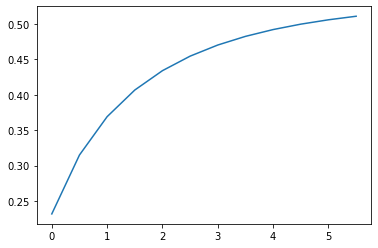

In [45]:
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline, make_interp_spline

fig, ax = plt.subplots()
x = np.arange(0,6,0.5)

plt.plot(x, HR_red_black, color='black', label='NIR')
plt.plot(x, HR_red_soil, color='red', label='Red')
plt.xlabel("Canopy Green Leaf Area Index")
plt.ylabel("Bi-Hemispherical Reflectance")
plt.title("Red Band")
plt.legend()

#plt.savefig('Plot 1 New', dpi=1200) - this line of code saves the figure and names it 'Plot 1 New'